In [57]:
# Import necessary libraries and packages(we learned all these from class homework)
# Fully original code 
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score, classification_report

In [58]:
# Load the raw Kaggle CSV 
# Fully original code
DATA_PATH = "../data/lyrics_train.csv"
df = pd.read_csv(DATA_PATH)

print(df.shape)
df.head()

(290183, 5)


,Artist,Song,Genre,Language,Lyrics
0,12 stones,world so cold,Rock,en,"It starts with pain, followed by hate\nFueled ..."
1,12 stones,broken,Rock,en,Freedom!\nAlone again again alone\nPatiently w...
2,12 stones,3 leaf loser,Rock,en,"Biting the hand that feeds you, lying to the v..."
3,12 stones,anthem for the underdog,Rock,en,You say you know just who I am\nBut you can't ...
4,12 stones,adrenaline,Rock,en,My heart is beating faster can't control these...


In [59]:
# Clean the dataset:
# 1. Drop rows with missing lyrics or genre
# 2. Keep only English lyrics
# Fully original code

df_clean = df.dropna(subset=["Lyrics", "Genre"]).copy()
df_clean = df_clean[df_clean["Language"] == "en"].copy()

print("After basic cleaning:", df_clean.shape)

# Look at the most common genres
genre_counts = df_clean["Genre"].value_counts()
genre_counts.head(20)


After basic cleaning: (250197, 5)


Genre
Rock          107145
Pop            86298
Metal          19133
Jazz           13314
Folk            8169
Indie           7240
R&B             2765
Hip-Hop         2238
Electronic      2005
Country         1890
Name: count, dtype: int64

In [60]:
# Keep top 5 genres and make a smaller dataset
# Fully original code

top_genres = genre_counts.head(5).index.tolist()
print("Top genres:", top_genres)

df_top = df_clean[df_clean["Genre"].isin(top_genres)].copy()
print("After keeping top 5 genres:", df_top.shape)

# limit to at most 50k songs so it run faster on my laptop
max_rows = 50000
if len(df_top) > max_rows:
    df_top = df_top.sample(n=max_rows, random_state=145)
    print("After downsampling:", df_top.shape)

# Rename columns to easier names
df_top = df_top.rename(columns={"Lyrics": "lyrics", "Genre": "genre"})
df_top.head()

Top genres: ['Rock', 'Pop', 'Metal', 'Jazz', 'Folk']
After keeping top 5 genres: (234059, 5)
After downsampling: (50000, 5)


,Artist,Song,genre,Language,lyrics
145048,the rolling stones,terrifying,Rock,en,No matter what you say \nNo matter what you do...
87382,sean paul,police (skit),Pop,en,"Officer:\nPull ova man, pull ova, pull ova\nSt..."
258552,colt ford,this is our song (remix),Rock,en,yeah yeah\ncolt ford\nthis is the remix\ni'm s...
270334,asher monroe,good vs evil,Pop,en,i got so much shit up on my mind\ni hope i mak...
115650,one direction,she's not afraid,Pop,en,"Yeah\nAha\nOne, two, three, four!\nSneaks out ..."


In [61]:
# Make a train (60%), validation(20%), and test split(20%)
# Fully original code

X_text = df_top["lyrics"].values
y = df_top["genre"].values


X_train, X_temp, y_train, y_temp = train_test_split(
    X_text,
    y,
    test_size=0.4,
    random_state=145,
    stratify=y
)

X_val, X_test, y_val, y_test = train_test_split(
    X_temp,
    y_temp,
    test_size=0.5,
    random_state=145,
    stratify=y_temp
)

len(X_train), len(X_val), len(X_test)

(30000, 10000, 10000)

In [62]:
# Turn lyrics into TF-IDF features (bag-of-words)

# AI consulted here for TF-IDF vectorization. Specifically, I learned from GPT what is TF-IDF, 
# and how to use TfidfVectorizer from sklearn.feature_extraction.text, 
# and then I looked at the example code generated from GPT.
# However, the actual implementation is fully original and I did not copy any code from GPT or other sources.

max_features = 20000  # the vocabulary size

tfidf = TfidfVectorizer(
    max_features=max_features,
    stop_words="english"
)

X_train_tfidf = tfidf.fit_transform(X_train)
X_val_tfidf = tfidf.transform(X_val)
X_test_tfidf = tfidf.transform(X_test)

X_train_tfidf.shape

(30000, 20000)

In [63]:
# Try a few c values and check performance on the validation set
# AI assited: Multiple bugs occured from sklearn usage, I had to debug with the help of GPT's explinations.
# However, the actual implementation is fully original and I did not copy any code from GPT or other sources.

C_values = [0.1, 1.0, 10.0]
val_results = []

for C in C_values:
    print("Training logistic regression with C =", C)
    logreg = LogisticRegression(
        C=C,
        max_iter=1000,
        n_jobs=-1,
    )
    logreg.fit(X_train_tfidf, y_train)

    y_val_pred = logreg.predict(X_val_tfidf)
    acc = accuracy_score(y_val, y_val_pred)
    f1 = f1_score(y_val, y_val_pred, average="macro")

    val_results.append({
        "C": C,
        "accuracy": acc,
        "macro_f1": f1
    })

    print("  val accuracy:", acc)
    print("  val macro-F1:", f1)

val_results

Training logistic regression with C = 0.1


/Users/hillll/Desktop/CS145 Final Project/.venv/lib/python3.14/site-packages/sklearn/linear_model/_logistic.py:1184: FutureWarning: 'n_jobs' has no effect since 1.8 and will be removed in 1.10. You provided 'n_jobs=-1', please leave it unspecified.
  warnings.warn(msg, category=FutureWarning)


  val accuracy: 0.5828
  val macro-F1: 0.2720651260766269
Training logistic regression with C = 1.0


/Users/hillll/Desktop/CS145 Final Project/.venv/lib/python3.14/site-packages/sklearn/linear_model/_logistic.py:1184: FutureWarning: 'n_jobs' has no effect since 1.8 and will be removed in 1.10. You provided 'n_jobs=-1', please leave it unspecified.
  warnings.warn(msg, category=FutureWarning)


  val accuracy: 0.617
  val macro-F1: 0.43129175888991594
Training logistic regression with C = 10.0


/Users/hillll/Desktop/CS145 Final Project/.venv/lib/python3.14/site-packages/sklearn/linear_model/_logistic.py:1184: FutureWarning: 'n_jobs' has no effect since 1.8 and will be removed in 1.10. You provided 'n_jobs=-1', please leave it unspecified.
  warnings.warn(msg, category=FutureWarning)


  val accuracy: 0.6052
  val macro-F1: 0.46480174767225335


[{'C': 0.1, 'accuracy': 0.5828, 'macro_f1': 0.2720651260766269},
 {'C': 1.0, 'accuracy': 0.617, 'macro_f1': 0.43129175888991594},
 {'C': 10.0, 'accuracy': 0.6052, 'macro_f1': 0.46480174767225335}]

In [64]:
# Pick the C with the best macro-F1
# Original code, just used GPT to proofread a small syntax error.

best_index = 0
best_f1 = val_results[0]["macro_f1"]

for i in range(1, len(val_results)):
    if val_results[i]["macro_f1"] > best_f1:
        best_f1 = val_results[i]["macro_f1"]
        best_index = i

best_C = val_results[best_index]["C"]
best_C, best_f1


(10.0, 0.46480174767225335)

In [65]:
# Final TF-IDF + logistic regression model on the test set
# Original code, just used GPT to proofread a syntax error 
# that showed up in y_test_pred = logreg_tfidf.predict(X_test_tfidf)


logreg_tfidf = LogisticRegression(
    C=best_C,
    max_iter=1000,
)

logreg_tfidf.fit(X_train_tfidf, y_train)

y_test_pred = logreg_tfidf.predict(X_test_tfidf)
test_acc = accuracy_score(y_test, y_test_pred)
test_f1  = f1_score(y_test, y_test_pred, average="macro")

print("TF-IDF + Logistic Regression")
print("Best C from validation:", best_C)
print("Test accuracy:", test_acc)
print("Test macro-F1:", test_f1)
print()
print(classification_report(y_test, y_test_pred))


TF-IDF + Logistic Regression
Best C from validation: 10.0
Test accuracy: 0.6096
Test macro-F1: 0.47316802572481126

              precision    recall  f1-score   support

        Folk       0.27      0.07      0.11       357
        Jazz       0.63      0.41      0.50       580
       Metal       0.58      0.42      0.49       808
         Pop       0.62      0.62      0.62      3660
        Rock       0.61      0.70      0.65      4595

    accuracy                           0.61     10000
   macro avg       0.54      0.44      0.47     10000
weighted avg       0.60      0.61      0.60     10000



In [66]:
# MiniLM embeddings (sentence-transformers)
# AI assisted: I learned about MiniLM embeddings from GPT and how to use sentence-transformers library.
from sentence_transformers import SentenceTransformer
from sklearn.preprocessing import StandardScaler

# Load a small pre-trained text model, MiniLM
# Input: full lyrics text
# Output: one fixed-length vector per song
embed_model = SentenceTransformer("all-MiniLM-L6-v2")

In [67]:
# Helper: run the model on a list of lyrics in small batches
# AI-assisted: I used AI to help sketch the batching approach, 
# after I learned it, final code edited by me

def embed_text_list(text_list, batch_size=64):
    vectors = []
    n = len(text_list)
    for start in range(0, n, batch_size):
        end = min(start + batch_size, n)
        batch = list(text_list[start:end])
        batch_vecs = embed_model.encode(batch, show_progress_bar=False)
        vectors.append(batch_vecs)
    return np.vstack(vectors)

In [68]:
# Compute embeddings for train, validation, and test sets
# Fully original code

X_train_embed = embed_text_list(X_train)
X_val_embed = embed_text_list(X_val)
X_test_embed = embed_text_list(X_test)
X_train_embed.shape

(30000, 384)

In [69]:
# Standardize embedding features to help logistic regression
# Fully original code

scaler = StandardScaler()

X_train_embed_std = scaler.fit_transform(X_train_embed)
X_val_embed_std = scaler.transform(X_val_embed)
X_test_embed_std = scaler.transform(X_test_embed)


In [70]:
# Try a few C values for logistic regression on embedding features
# AI-assisted: GPT helped me debug a shape mismatch (using the scaled arrays for train, val, test)
# and fix a small variable name error.
# GPt also helped me to drop n_jobs to remove warning
# However, the tuning loop + evaluation metrics are my work.

C_values = [0.1, 1.0, 10.0]
val_results_embed = []

for C in C_values:
    print("Training logistic regression with C =", C)
    logreg = LogisticRegression(C=C, max_iter=1000)  
    logreg.fit(X_train_embed_std, y_train)

    y_val_pred = logreg.predict(X_val_embed_std)
    acc = accuracy_score(y_val, y_val_pred)
    f1 = f1_score(y_val, y_val_pred, average="macro")

    val_results_embed.append({"C": C, "accuracy": acc, "macro_f1": f1})
    print("  val accuracy:", acc)
    print("  val macro-F1:", f1)

val_results_embed

Training logistic regression with C = 0.1
  val accuracy: 0.6171
  val macro-F1: 0.45114503082456947
Training logistic regression with C = 1.0
  val accuracy: 0.617
  val macro-F1: 0.4533314814257764
Training logistic regression with C = 10.0
  val accuracy: 0.617
  val macro-F1: 0.45343512457630303


[{'C': 0.1, 'accuracy': 0.6171, 'macro_f1': 0.45114503082456947},
 {'C': 1.0, 'accuracy': 0.617, 'macro_f1': 0.4533314814257764},
 {'C': 10.0, 'accuracy': 0.617, 'macro_f1': 0.45343512457630303}]

In [71]:
# Pick the C with the best macro F1 for the embedding model
# Fully original code

best_index = 0
best_f1 = val_results[0]["macro_f1"]

for i in range(1, len(val_results)):
    if val_results[i]["macro_f1"] > best_f1:
        best_f1 = val_results[i]["macro_f1"]
        best_index = i

best_C_embed = val_results[best_index]["C"]
best_C_embed, best_f1

(10.0, 0.46480174767225335)

In [72]:
# Final embedding-based logistic regression model on the test set
# AI-assisted: GPT helped me remove an unnecessary parameter (n_jobs) and make the print labels consistent

logreg_embed = LogisticRegression(
    C=best_C_embed,
    max_iter=1000
)

logreg_embed.fit(X_train_embed_std, y_train)

y_test_pred_embed = logreg_embed.predict(X_test_embed_std)
test_acc_embed = accuracy_score(y_test, y_test_pred_embed)
test_f1_embed = f1_score(y_test, y_test_pred_embed, average="macro")

print("MiniLM Embeddings + Logistic Regression")
print("Best C from validation:", best_C_embed)
print("Test accuracy:", test_acc_embed)
print("Test macro-F1:", test_f1_embed)
print()
print(classification_report(y_test, y_test_pred_embed))

MiniLM Embeddings + Logistic Regression
Best C from validation: 10.0
Test accuracy: 0.6092
Test macro-F1: 0.4425753446172217

              precision    recall  f1-score   support

        Folk       0.33      0.03      0.05       357
        Jazz       0.53      0.31      0.39       580
       Metal       0.61      0.42      0.50       808
         Pop       0.64      0.59      0.62      3660
        Rock       0.59      0.74      0.66      4595

    accuracy                           0.61     10000
   macro avg       0.54      0.42      0.44     10000
weighted avg       0.60      0.61      0.59     10000



In [73]:
# Turn lyrics into TF-IDF features 
# Then fit vectorizer on the training set
# Fully original code

tfidf = TfidfVectorizer(
    max_features=20000,
    stop_words="english"
)
X_train_tfidf = tfidf.fit_transform(X_train)

X_train_tfidf.shape

(30000, 20000)

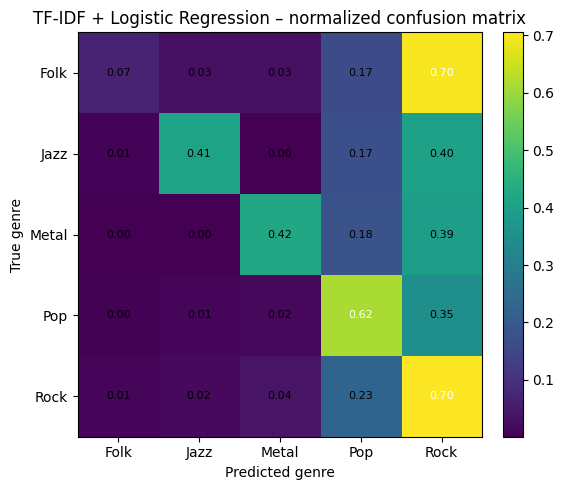

In [ ]:
# Confusion matrix plot (normalized) for TF-IDF + logistic regression
# AI-assisted: I used AI to help recall the sklearn confusion_matrix + matplotlib heatmap pattern.
# GPT also helped me debug a divide-by-zero / NaN issue when normalizing the confusion matrix rows.
# However, I used my own model outputs (logreg_tfidf predictions) and chose the label order for the plot.
# I also wrote the workflow steps here fully by myself, and I had scratch paper for notes to proof of the steps

from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import numpy as np


y_test_pred_tfidf = logreg_tfidf.predict(X_test_tfidf)

# Confusion matrix with fixed label order 
genre_labels = ["Folk", "Jazz", "Metal", "Pop", "Rock"]
cm_tfidf = confusion_matrix(y_test, y_test_pred_tfidf, labels=genre_labels)

# Normalize rows with true labels so each row sums to 1
row_sums = cm_tfidf.sum(axis=1, keepdims=True)
cm_tfidf_norm = np.divide(cm_tfidf, row_sums, where=row_sums != 0)

# Plot heatmap
fig, ax = plt.subplots(figsize=(6, 5))
im = ax.imshow(cm_tfidf_norm)

ax.set_xticks(np.arange(len(genre_labels)))
ax.set_yticks(np.arange(len(genre_labels)))
ax.set_xticklabels(genre_labels)
ax.set_yticklabels(genre_labels)

ax.set_xlabel("Predicted genre")
ax.set_ylabel("True genre")
ax.set_title("TF-IDF + Logistic Regression – normalized confusion matrix")

# Add numbers in each cell
for i in range(cm_tfidf_norm.shape[0]):
    for j in range(cm_tfidf_norm.shape[1]):
        value = cm_tfidf_norm[i, j]
        ax.text(
            j, i, f"{value:.2f}",
            ha="center", va="center",
            color="white" if value > 0.5 else "black",
            fontsize=8,
        )

fig.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
plt.tight_layout()
plt.show()

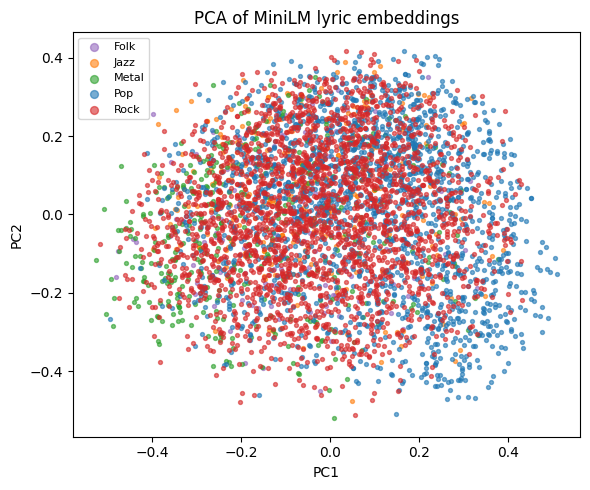

In [75]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import numpy as np

# PCA scatter plot of MiniLM embeddings2D
# AI-assisted: GPT helped me debug the subsampling and indexing step
# because my original embeddings were not consistent with the labels,

n_sample = min(5000, len(X_train_embed))
rng = np.random.default_rng(0)
indices = rng.choice(len(X_train_embed), size=n_sample, replace=False)

X_sample = X_train_embed[indices]
y_sample = np.array(y_train)[indices]

pca = PCA(n_components=2, random_state=0)
X_2d = pca.fit_transform(X_sample)

genre_labels = ["Folk", "Jazz", "Metal", "Pop", "Rock"]
colors = {
    "Folk": "tab:purple",
    "Jazz": "tab:orange",
    "Metal": "tab:green",
    "Pop": "tab:blue",
    "Rock": "tab:red",
}

plt.figure(figsize=(6, 5))
for g in genre_labels:
    mask = (y_sample == g)
    plt.scatter(X_2d[mask, 0], X_2d[mask, 1], s=8, alpha=0.6, label=g, color=colors[g])

plt.xlabel("PC1")
plt.ylabel("PC2")
plt.title("PCA of MiniLM lyric embeddings")
plt.legend(markerscale=2, fontsize=8)
plt.tight_layout()
plt.show()


## Extension: Autoencoder on MiniLM embeddings

In [ ]:
# Autoencoder using PyTorch on MiniLM embeddings
# Original code but with GPT debug for a small PyTorch syntax

import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

print("Train embeddings shape:", X_train_embed.shape)
print("Val embeddings shape:", X_val_embed.shape)
print("Test embeddings shape:", X_test_embed.shape)

Using device: cpu
Train embeddings shape: (30000, 384)
Val embeddings shape: (10000, 384)
Test embeddings shape: (10000, 384)


In [77]:
# Turn numpy arrays into float32 tensors
# For an autoencoder, target == input (reconstruction)
# DataLoaders: shuffle train, keep val fixed
# AI-assisted: I used AI to confirm the TensorDataset/DataLoader pattern
# After learning from GPT, the code and batch size choices are original

X_train_tensor = torch.tensor(X_train_embed, dtype=torch.float32)
X_val_tensor   = torch.tensor(X_val_embed, dtype=torch.float32)

train_dataset = TensorDataset(X_train_tensor, X_train_tensor)
val_dataset   = TensorDataset(X_val_tensor, X_val_tensor)

train_loader = DataLoader(train_dataset, batch_size=256, shuffle=True)
val_loader   = DataLoader(val_dataset, batch_size=256, shuffle=False)

len(train_dataset), len(val_dataset)


(30000, 10000)

In [78]:
# encoder: input_dim -> 128-> latent_dim
# decoder: latent_dim -> 128-> input_dim
# AI-assisted: Continue from last chunk, I used AI to check the basic PyTorch autoencoder pattern, 
# mainly about the encoder/decoder and forward patterns,
# then I chose the hidden size 128 and latent_dim and ran the experiments code myself
input_dim = X_train_embed.shape[1]   
latent_dim = 64                      

class Autoencoder(nn.Module):
    def __init__(self, input_dim, latent_dim):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, 128),
            nn.ReLU(),
            nn.Linear(128, latent_dim),)
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, 128),
            nn.ReLU(),
            nn.Linear(128, input_dim),)
        
    def forward(self, x):
        z = self.encoder(x)
        x_recon = self.decoder(z)
        return x_recon

model = Autoencoder(input_dim=input_dim, latent_dim=latent_dim).to(device)
model


Autoencoder(
  (encoder): Sequential(
    (0): Linear(in_features=384, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=64, bias=True)
  )
  (decoder): Sequential(
    (0): Linear(in_features=64, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=384, bias=True)
  )
)

In [79]:
# Training setup + loop (autoencoder reconstruction)
# AI-assisted: GPT taught me the train/eval loop structure
# While the final code are original, I used AI to debug a small syntax error somewhere that I don't remember

criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

num_epochs = 10

for epoch in range(num_epochs):
    model.train()
    train_loss = 0.0
    for batch_x, _ in train_loader:
        batch_x = batch_x.to(device)

        optimizer.zero_grad()
        x_recon = model(batch_x)
        loss = criterion(x_recon, batch_x)
        loss.backward()
        optimizer.step()

        train_loss += loss.item() * batch_x.size(0)

    train_loss /= len(train_dataset)

    # validation
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for batch_x, _ in val_loader:
            batch_x = batch_x.to(device)
            x_recon = model(batch_x)
            loss = criterion(x_recon, batch_x)
            val_loss += loss.item() * batch_x.size(0)

    val_loss /= len(val_dataset)

    print(f"Epoch {epoch+1}/{num_epochs}  "
          f"train_loss = {train_loss:.4f}  val_loss = {val_loss:.4f}")


Epoch 1/10  train_loss = 0.0018  val_loss = 0.0013
Epoch 2/10  train_loss = 0.0012  val_loss = 0.0010
Epoch 3/10  train_loss = 0.0010  val_loss = 0.0009
Epoch 4/10  train_loss = 0.0009  val_loss = 0.0009
Epoch 5/10  train_loss = 0.0008  val_loss = 0.0008
Epoch 6/10  train_loss = 0.0008  val_loss = 0.0008
Epoch 7/10  train_loss = 0.0008  val_loss = 0.0007
Epoch 8/10  train_loss = 0.0007  val_loss = 0.0007
Epoch 9/10  train_loss = 0.0007  val_loss = 0.0007
Epoch 10/10  train_loss = 0.0007  val_loss = 0.0007


In [80]:
# Encode a dataset into latent vectors using the trained encoder
# AI-assisted: GPT helped me outline this helper,
# But I learned it and I plugged it into my pipeline and verified the output and code myself

import numpy as np

def encode_dataset(dataloader, model, device):
    model.eval()
    zs = []
    with torch.no_grad():
        for batch_x, _ in dataloader:
            batch_x = batch_x.to(device)
            z = model.encoder(batch_x)
            zs.append(z.cpu().numpy())
    return np.vstack(zs)

# Build loaders with no shuffle so the latent rows stay aligned with train val and test
train_loader_noshuffle = DataLoader(train_dataset, batch_size=256, shuffle=False)
val_loader_noshuffle   = DataLoader(val_dataset,   batch_size=256, shuffle=False)

# Test loader with same pattern
X_test_tensor = torch.tensor(X_test_embed, dtype=torch.float32)
test_dataset  = TensorDataset(X_test_tensor, X_test_tensor)
test_loader   = DataLoader(test_dataset, batch_size=256, shuffle=False)

# Encode to latent, n x latent_dim
X_train_latent = encode_dataset(train_loader_noshuffle, model, device)
X_val_latent   = encode_dataset(val_loader_noshuffle,   model, device)
X_test_latent  = encode_dataset(test_loader, model, device)

print("Latent shapes:", X_train_latent.shape, X_val_latent.shape, X_test_latent.shape)


Latent shapes: (30000, 64) (10000, 64) (10000, 64)


In [81]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score, classification_report

# Logistic regression on AE latent vectors (tune C on validation)
# AI-assisted: GPT taught me how to adapt my earlier tuning loop to the latent features
# Then I designed the code logic and used GPT for variable names and debug for small issues in n_jobs warnings 

Cs = [0.1, 1, 10]
best_C_latent = None
best_val_f1_latent = -1

for C in Cs:
    logreg_latent = LogisticRegression(
        C=C,
        max_iter=1000
    )
    logreg_latent.fit(X_train_latent, y_train)

    y_val_pred_latent = logreg_latent.predict(X_val_latent)
    val_f1 = f1_score(y_val, y_val_pred_latent, average="macro")
    print(f"C={C} | val macro-F1 (latent)={val_f1:.3f}")

    if val_f1 > best_val_f1_latent:
        best_val_f1_latent = val_f1
        best_C_latent = C

print("Best C for latent features:", best_C_latent)

# Retrain on train+val using the best C then evaluate on test
X_trainval_latent = np.vstack([X_train_latent, X_val_latent])
y_trainval = np.concatenate([y_train, y_val])

logreg_latent_final = LogisticRegression(
    C=best_C_latent,
    max_iter=1000
)
logreg_latent_final.fit(X_trainval_latent, y_trainval)

y_test_pred_latent = logreg_latent_final.predict(X_test_latent)
test_acc_latent = accuracy_score(y_test, y_test_pred_latent)
test_f1_latent = f1_score(y_test, y_test_pred_latent, average="macro")

print("\nAutoencoder latent + Logistic Regression (Test)")
print("Best C from validation:", best_C_latent)
print("Test accuracy:", test_acc_latent)
print("Test macro-F1:", test_f1_latent)
print()
print(classification_report(y_test, y_test_pred_latent))

C=0.1 | val macro-F1 (latent)=0.339
C=1 | val macro-F1 (latent)=0.400
C=10 | val macro-F1 (latent)=0.412
Best C for latent features: 10

Autoencoder latent + Logistic Regression (Test)
Best C from validation: 10
Test accuracy: 0.5939
Test macro-F1: 0.39662877635055044

              precision    recall  f1-score   support

        Folk       0.50      0.00      0.01       357
        Jazz       0.55      0.19      0.28       580
       Metal       0.60      0.36      0.45       808
         Pop       0.62      0.58      0.60      3660
        Rock       0.58      0.74      0.65      4595

    accuracy                           0.59     10000
   macro avg       0.57      0.37      0.40     10000
weighted avg       0.59      0.59      0.57     10000



In [82]:
# Summary table of test performance
# Fully original code

import pandas as pd

results_summary = pd.DataFrame([
    {"Features": "TF-IDF (20k)",        "Test acc": 0.6096, "Test macro-F1": 0.4732},
    {"Features": "MiniLM (384)",        "Test acc": 0.6092, "Test macro-F1": 0.4426},
    {"Features": "MiniLM-AE (64 dim)",  "Test acc": 0.5952, "Test macro-F1": 0.3912},
])

results_summary


,Features,Test acc,Test macro-F1
0,TF-IDF (20k),0.6096,0.4732
1,MiniLM (384),0.6092,0.4426
2,MiniLM-AE (64 dim),0.5952,0.3912


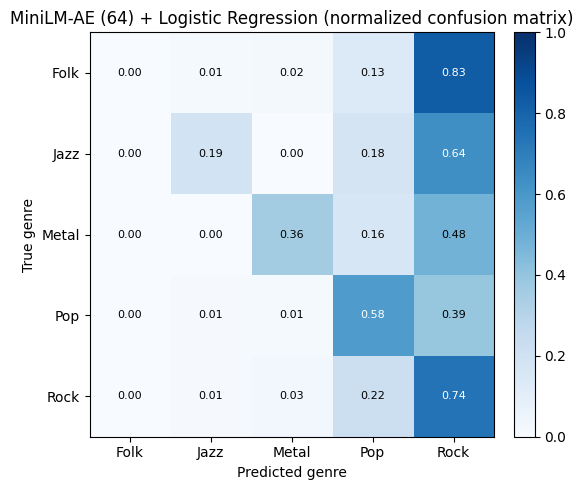

In [83]:
# Normalized confusion matrix for MiniLM-AE (64) + logistic regression
# AI-assisted: I used GPT for the basic matplotlib heatmap pattern and to check the row-normalization step.
# Then I learned it and wrote code for my variables 

from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import numpy as np

genre_labels = ["Folk", "Jazz", "Metal", "Pop", "Rock"]

cm_latent = confusion_matrix(y_test, y_test_pred_latent, labels=genre_labels)
row_sums = cm_latent.sum(axis=1, keepdims=True)

cm_latent_norm = np.divide(
    cm_latent,
    row_sums,
    out=np.zeros_like(cm_latent, dtype=float),
    where=row_sums != 0
)

fig, ax = plt.subplots(figsize=(6, 5))
im = ax.imshow(cm_latent_norm, cmap="Blues", vmin=0, vmax=1)

ax.set_xticks(np.arange(len(genre_labels)))
ax.set_yticks(np.arange(len(genre_labels)))
ax.set_xticklabels(genre_labels)
ax.set_yticklabels(genre_labels)

ax.set_xlabel("Predicted genre")
ax.set_ylabel("True genre")
ax.set_title("MiniLM-AE (64) + Logistic Regression (normalized confusion matrix)")

for i in range(cm_latent_norm.shape[0]):
    for j in range(cm_latent_norm.shape[1]):
        v = cm_latent_norm[i, j]
        ax.text(j, i, f"{v:.2f}",
                ha="center", va="center",
                color="white" if v > 0.5 else "black",
                fontsize=8)

fig.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
plt.tight_layout()
plt.show()

In [84]:
# Inspect the TF-IDF logistic regression weights to see which words push each genre.
# AI-assisted: I used GPT to remind me how to map model.coef_ back to words from the vectorizer.
# Then I learned and wrote code myself for my variables


tfidf_model = logreg_tfidf
import numpy as np

# Find the fitted TfidfVectorizer from earlier in the notebook.
tfidf_vec = None
for name, obj in list(globals().items()):  # <-- snapshot to avoid "dict changed size" error
    if isinstance(obj, TfidfVectorizer) and hasattr(obj, "vocabulary_") and obj.vocabulary_:
        tfidf_vec = obj
        if len(tfidf_vec.vocabulary_) == tfidf_model.coef_.shape[1]:
            print(f"Using '{name}' as the TF-IDF vectorizer.")
            break
        else:
            tfidf_vec = None

if tfidf_vec is None:
    raise RuntimeError(
        "Couldn't auto-locate the fitted TfidfVectorizer. "
        "Set it manually, e.g. tfidf_vec = tfidf"
    )

feature_names = tfidf_vec.get_feature_names_out()
class_names = tfidf_model.classes_

print("Class order used by the model:", class_names)

# Top-weighted words per class
top_k = 15

for i, cls in enumerate(class_names):
    coefs = tfidf_model.coef_[i]
    top_idx = np.argsort(coefs)[-top_k:][::-1]

    print(f"\nTop {top_k} TF-IDF features for '{cls}':")
    for j in top_idx:
        print(f"  {feature_names[j]:20s}  {coefs[j]:.3f}")

Using 'tfidf' as the TF-IDF vectorizer.
Class order used by the model: ['Folk' 'Jazz' 'Metal' 'Pop' 'Rock']

Top 15 TF-IDF features for 'Folk':
  slide                 4.694
  ledge                 4.417
  er                    4.240
  coins                 4.233
  scrapes               4.226
  magdalene             4.152
  pushed                4.052
  frog                  4.047
  tower                 3.940
  noon                  3.936
  afterlife             3.896
  shield                3.843
  wife                  3.785
  qualifications        3.747
  sorrow                3.718

Top 15 TF-IDF features for 'Jazz':
  romance               6.621
  certain               5.724
  wail                  4.564
  cottage               4.502
  gladly                4.438
  grand                 4.425
  blackbird             4.351
  marvelous             4.268
  cling                 4.196
  vow                   4.097
  chicago               4.074
  creep                 3.989
  discover

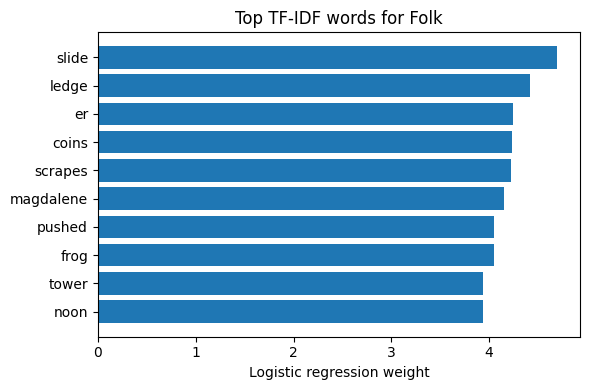

In [85]:
# The plot show which TF-IDF words most push the model toward a target genre (top positive LogReg weights).
# Uses the fitted TF-IDF vocab + learned coefficients for analysis 
# AI-assisted: I got this idea from GPT, but checked-in with Teal at the end of last class.
# Code is fully original
import numpy as np
import matplotlib.pyplot as plt

tfidf_model = logreg_tfidf     
tfidf_vec   = tfidf          

feature_names = np.array(tfidf_vec.get_feature_names_out())
class_names   = tfidf_model.classes_

target_class = "Folk"
c_idx = np.where(class_names == target_class)[0][0]

coefs = tfidf_model.coef_[c_idx]
top_k = 10
top_idx = np.argsort(coefs)[-top_k:][::-1]

top_words   = feature_names[top_idx]
top_weights = coefs[top_idx]

plt.figure(figsize=(6, 4))
plt.barh(top_words[::-1], top_weights[::-1])
plt.xlabel("Logistic regression weight")
plt.title(f"Top TF-IDF words for {target_class}")
plt.tight_layout()
plt.show()

